# Installation Setup

In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import os
import sys
import json
import random
import pickle
import itertools
from datetime import datetime as dt
from multiprocessing import Pool

import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from pandas.tseries.offsets import *
from dateutil.relativedelta import *
import pandas_datareader.data as web
from fredapi import Fred
fred = Fred(api_key='b0363f9c9d853b92b27e06c4727bc2ea')

from scipy import stats
import statsmodels.api as sm

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

import gym
from tqdm import tqdm
import pytz

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from finrl import config
from finrl import config_tickers
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

In [61]:
import StockPortfolioEnv
import utils
import TD3_BC

In [62]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 5)

from IPython.core.pylabtools import figsize
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('mode.use_inf_as_na', True)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 500)
idx = pd.IndexSlice
import warnings
warnings.filterwarnings('ignore')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Environment configuration
> A gym-style portfolio allocation environment for agents to interact. It is handy to compare the performances.

In [63]:
train_data = pd.read_csv('data/train_data.csv', index_col=0).loc[:100]
trade_data = pd.read_csv('data/trade_data.csv', index_col=0)
full_data = pd.read_csv('data/full_data.csv', index_col=0)

In [64]:
train_data

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,fake_macd,fake_rsi_30,fake_cci_30,fake_dx_30,moribvol,equal,greedy,mean-var
0,2007-01-03,16.630,17.250,16.620,8.712,5540800,CNP,2,0.000,8.741,8.698,100.000,66.667,100.000,8.712,8.712,-1.485,-136.781,70.362,-0.272,0.061,0.091,0,0.091
0,2007-01-03,66.030,66.250,64.240,44.847,6297900,DVN,2,0.000,8.741,8.698,100.000,66.667,100.000,44.847,44.847,0.418,184.381,-0.403,1.417,0.091,0.091,0,0.091
0,2007-01-03,18.250,18.790,18.200,8.567,282800,FNB,2,0.000,8.741,8.698,100.000,66.667,100.000,8.567,8.567,-0.338,13.921,-8.875,30.901,0.015,0.091,0,0.091
0,2007-01-03,12.230,12.350,12.080,8.387,3313000,IPG,2,0.000,8.741,8.698,100.000,66.667,100.000,8.387,8.387,-0.750,92.651,-48.465,30.171,0.045,0.091,0,0.091
0,2007-01-03,21.530,21.890,21.160,17.301,565300,JKHY,2,0.000,8.741,8.698,100.000,66.667,100.000,17.301,17.301,-0.338,-244.724,170.517,38.534,0.167,0.091,0,0.091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,2007-05-29,17.615,17.750,17.525,13.211,451400,MLI,1,0.313,13.458,12.478,61.715,84.867,29.465,12.562,11.836,-0.526,-15.131,-49.159,7.702,0.015,0.091,0,0.091
100,2007-05-29,32.310,32.470,31.770,23.689,1389200,SEE,1,-0.052,25.211,23.780,45.115,-133.105,23.164,24.399,24.022,-1.902,142.070,-51.396,21.746,0.030,0.091,0,0.091
100,2007-05-29,20.286,20.430,20.199,16.692,232136,TR,1,-0.240,17.456,16.246,42.180,-80.225,26.487,17.125,17.309,0.089,-67.627,-150.958,36.731,0.152,0.091,0,0.091
100,2007-05-29,30.470,30.750,30.140,30.510,934900,VRTX,1,0.099,32.184,29.490,48.120,-65.654,6.408,31.020,30.056,0.843,98.402,76.781,43.900,0.121,0.091,0,0.091


In [65]:
# Environment arguments 
stock_dimension = len(train_data.tic.unique())
state_space = stock_dimension
tech_indicator_list = ['macd', 'rsi_30', 'cci_30', 'dx_30']
fake_tech_indicator_list = ['fake_macd', 'fake_rsi_30', 'fake_cci_30', 'fake_dx_30']
feature_dimension = len(tech_indicator_list)

print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
print(f"Feature Dimension: {feature_dimension}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicator_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-1
}

e_train_gym = StockPortfolioEnv.StockPortfolioEnv(df = train_data, **env_kwargs)
e_trade_gym = StockPortfolioEnv.StockPortfolioEnv(df = trade_data, **env_kwargs)
env = StockPortfolioEnv.StockPortfolioEnv(df = full_data, **env_kwargs)

Stock Dimension: 11, State Space: 11
Feature Dimension: 4


In [66]:
# Train
retail_train = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=train_data["moribvol"])
true_portfolio_train = e_train_gym.asset_memory
true_actions_train = e_train_gym.actions_memory

# Trade
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=trade_data["moribvol"])
true_portfolio_trade = e_trade_gym.asset_memory
true_actions_trade = e_trade_gym.actions_memory

# Full
_ = StockPortfolioEnv.sample_from_env(i=0, env=env, weights=full_data["moribvol"])
true_portfolio_full = env.asset_memory
true_actions_full = env.actions_memory

begin_total_asset:1000000
end_total_asset:1050488.408439199
Sharpe:  0.918497226264351
begin_total_asset:1000000
end_total_asset:2441370.145613215
Sharpe:  1.0078092209505938
begin_total_asset:1000000
end_total_asset:15669715.945135742
Sharpe:  0.8588476452597811


# Preprocess

In [67]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, scale_data=True):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            # Apply scaling if necessary
            if scale_data: 
                X = StandardScaler(with_mean=True, with_std=True).fit_transform(X)
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)
        else:
            self.X = torch.tensor(X).float()
            self.y = torch.tensor(y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [68]:
X = train_data[tech_indicator_list]
Y = train_data["moribvol"]
X_trade = trade_data[tech_indicator_list]
Y_trade = trade_data["moribvol"]

In [69]:
# Set seeds
seed = 0
e_train_gym.seed(seed)
e_train_gym.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

# Prepare dataset
X = X.astype(np.float32) 
Y = Y.astype(np.float32) 
X_trade = X_trade.astype(np.float32) 
Y_trade = Y_trade.astype(np.float32)

train_dataset = Dataset(X.values.reshape(-1, stock_dimension*feature_dimension), 
                        Y.values.reshape(-1, stock_dimension))

scaler = StandardScaler(with_mean=True, with_std=True).fit(X.values.reshape(-1, stock_dimension*feature_dimension))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

trade_dataset = Dataset(scaler.transform(X_trade.values.reshape(-1, stock_dimension*feature_dimension)), 
                        Y_trade.values.reshape(-1, stock_dimension),
                        scale_data=False)

full_dataset = Dataset(full_data[tech_indicator_list].values.reshape(-1, stock_dimension*feature_dimension).astype(np.float32), 
                       full_data["moribvol"].values.reshape(-1, stock_dimension).astype(np.float32), 
                       scale_data=False)

[0]

# Policy Gradient Theorem
A naive attempt

In [70]:
class NeuralNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim, max_action):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(state_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, action_dim)
        self.max_action = max_action

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        return self.max_action * F.softmax(self.l3(a))

In [71]:
def train(ann, optimizer, state_list, action_list, reward_list):
    trajectory_len = len(reward_list)
    return_array = np.zeros((trajectory_len,))
    g_return = 0.
    
    for i in range(trajectory_len-1,-1,-1):
        g_return = reward_list[i] + g_return
        return_array[i] = g_return

    loss = -torch.mean(torch.tensor(return_array, requires_grad=True))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 

    return loss.detach().cpu().numpy()

In [72]:
ann = NeuralNet(state_dim=stock_dimension*feature_dimension, 
                action_dim=stock_dimension, 
                hidden_dim=128, 
                max_action=float(e_train_gym.action_space.high[0]))

optimizer = torch.optim.Adam(ann.parameters(), lr=3e-4)
epsilon_min, epsilon_decay = 0.01, 0.97
noise_scale = 0.1
episodes = 100 # run agent for this many episodes

stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0

for ep in range(episodes):
    state = scaler.transform(np.asarray(e_train_gym.reset()).T.reshape(-1, stock_dimension*feature_dimension))[0]
    state = torch.from_numpy(state).float()
    stats_loss = 0.
    
    state_list = []
    action_list = []
    reward_list = []
    
    # train in each episode until episode is done
    while True:
        timesteps += 1
        
        # Select an action using epsilon-greedy exploration
        epsilon = max(epsilon_min, epsilon_decay**ep) # Decay epsilon over time
        action = ann(state).detach().numpy()
        if np.random.uniform() < epsilon:
            action = action + noise_scale * np.random.normal(size=action.shape)
        
        # Take the selected action and record the resulting state and reward
        next_state, reward, done, _ = e_train_gym.step(action)
        next_state = scaler.transform(np.asarray(next_state).T.reshape(-1, stock_dimension*feature_dimension))[0]
        next_state = torch.from_numpy(next_state).float()
        
        # enter action into the env
        total_reward += reward
        episode_length += 1
        
        # store agent's trajectory
        state_list.append(state)
        action_list.append(action)
        reward_list.append(reward)
        
        if done:
            stats_loss += train(ann, optimizer, state_list, action_list, reward_list)
            stats_rewards_list.append((ep, total_reward, episode_length))
            total_reward = 0
            episode_length = 0  
            if ep % stats_every == 0:
                print('Episode: {}'.format(ep),
                    'Timestep: {}'.format(timesteps),
                    'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                    'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                    'Loss: {:.3f}'.format(stats_loss/stats_every))
            break
        
        state = next_state

begin_total_asset:1000000
end_total_asset:1046204.2972047924
Sharpe:  0.8833550511982329
Episode: 0 Timestep: 101 Total reward: 0.0 Episode length: 101.0 Loss: -0.003
begin_total_asset:1000000
end_total_asset:1046663.351964881
Sharpe:  0.8963334554226928
begin_total_asset:1000000
end_total_asset:1039318.3603434857
Sharpe:  0.7718435433828753
begin_total_asset:1000000
end_total_asset:1042579.9451019625
Sharpe:  0.8328661860123497
begin_total_asset:1000000
end_total_asset:1046181.3770795793
Sharpe:  0.8855357467563119
begin_total_asset:1000000
end_total_asset:1047055.2553458994
Sharpe:  0.9099530850447165
begin_total_asset:1000000
end_total_asset:1043243.667329618
Sharpe:  0.8360682099607448
begin_total_asset:1000000
end_total_asset:1049733.5412964446
Sharpe:  0.9456484151873401
begin_total_asset:1000000
end_total_asset:1047445.9057483715
Sharpe:  0.9131989516460857
begin_total_asset:1000000
end_total_asset:1046952.5727166518
Sharpe:  0.8989675175351061
begin_total_asset:1000000
end_tota

begin_total_asset:1000000
end_total_asset:1047341.2636459145
Sharpe:  0.9085359900854951
begin_total_asset:1000000
end_total_asset:1047818.808258019
Sharpe:  0.9146547078419203
begin_total_asset:1000000
end_total_asset:1047729.7804100624
Sharpe:  0.9099320820520511
begin_total_asset:1000000
end_total_asset:1043372.1885336915
Sharpe:  0.8345771056777819
begin_total_asset:1000000
end_total_asset:1042384.9002664996
Sharpe:  0.8237728713032071
begin_total_asset:1000000
end_total_asset:1048546.4407509395
Sharpe:  0.9256091300365635
begin_total_asset:1000000
end_total_asset:1042248.0750254121
Sharpe:  0.8168674667965787
begin_total_asset:1000000
end_total_asset:1047912.0368038226
Sharpe:  0.9152064282502546
begin_total_asset:1000000
end_total_asset:1049774.9397210332
Sharpe:  0.9455694130485077
begin_total_asset:1000000
end_total_asset:1047792.3522229923
Sharpe:  0.9124575804594474
Episode: 60 Timestep: 6161 Total reward: 0.0 Episode length: 101.0 Loss: -0.003
begin_total_asset:1000000
end_t

# TD3
source from https://github.com/sfujim/TD3_BC/blob/main/main.py

In [73]:
# upper bound
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=train_data["greedy"])

begin_total_asset:1000000
end_total_asset:7948190.913022887
Sharpe:  18.427454317408852


In [74]:
def eval_policy(policy, eval_env, seed, mean, std, seed_offset=100, eval_episodes=1):
    eval_env.reset()
    eval_env.seed(seed + seed_offset)

    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = eval_env.reset(), False
        while not done:
            state = (np.array(state).reshape(1,-1) - mean)/std
            action = policy.select_action(state)
            state, reward, done, _ = eval_env.step(action)
            
            if done: break
            avg_reward += reward
            
    avg_reward /= eval_episodes
    # 	d4rl_score = eval_env.get_normalized_score(avg_reward) * 100

    print("---------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    # 	print(f"Evaluation over {eval_episodes} episodes")
    print("---------------------------------------")
    
    return avg_reward

## BC

In [75]:
# Experiment
policy = "TD3+BC" # Policy name
seed = 0 # Sets Gym, PyTorch and Numpy seeds
eval_freq = 1e1 # How often (time steps) we evaluate
max_timesteps = 1e2 # Max time steps to run environment
save_model = True # Save model and optimizer parameters
load_model = "" # Model load file name, "" doesn't load, "default" uses file_name
file_name = f"BC_{seed}"

# TD3
batch_size = 256 # Batch size for both actor and critic
discount = 0.99 # Discount factor
tau = 0.005 # Target network update rate
policy_noise = 0.2 # Noise added to target policy during critic update
noise_clip = 0.5 # Range to clip target policy noise
policy_freq = 1 # Frequency of delayed policy updates

# TD3 + BC
alpha = 0
normalize = True

# Set seeds
e_train_gym.seed(seed)
e_train_gym.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

state_dim = e_train_gym.observation_space.shape[0] * e_train_gym.observation_space.shape[1]
action_dim = e_train_gym.action_space.shape[0] 
max_action = float(e_train_gym.action_space.high[0])

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": discount,
    "tau": tau,
    # TD3
    "policy_noise": policy_noise * max_action,
    "noise_clip": noise_clip * max_action,
    "policy_freq": policy_freq,
    # TD3 + BC
    "alpha": alpha
}

# Initialize policy
policy = TD3_BC.TD3_BC(**kwargs)

# Replay buffer and flatten
replay_buffer = utils.ReplayBuffer(state_dim, action_dim)
replay_buffer.convert_D4RL(retail_train)
replay_buffer.state = replay_buffer.state.reshape(replay_buffer.state.shape[0], -1)
replay_buffer.next_state = replay_buffer.next_state.reshape(replay_buffer.next_state.shape[0], -1)

# standardize
mean, std = (replay_buffer.normalize_states() if normalize else (0, 1))

[0]

In [76]:
days = len(e_train_gym.actions_memory)
evaluations = []
portfolio_values = []
fitted = []

for t in range(int(max_timesteps)):
    policy.train(replay_buffer, batch_size)
    # Evaluate episode
    if (t + 1) % eval_freq == 0: 
        print(f"Time steps: {t+1}")
        evaluations.append(eval_policy(policy, e_train_gym, seed, mean, std))
        portfolio_values.append(e_train_gym.portfolio_value)        
        fitted.append(np.mean((np.array(e_train_gym.actions_memory) - np.array(Y.loc[:days-1].values.reshape(-1, 11)) ** 2)))

Time steps: 10
begin_total_asset:1000000
end_total_asset:1049334.9891881833
Sharpe:  0.9279110576016543
---------------------------------------
Evaluation over 1 episodes: 0.052
---------------------------------------
Time steps: 20
begin_total_asset:1000000
end_total_asset:1050780.0069173723
Sharpe:  0.9473387081472694
---------------------------------------
Evaluation over 1 episodes: 0.054
---------------------------------------
Time steps: 30
begin_total_asset:1000000
end_total_asset:1048814.205852857
Sharpe:  0.9125567596366834
---------------------------------------
Evaluation over 1 episodes: 0.052
---------------------------------------
Time steps: 40
begin_total_asset:1000000
end_total_asset:1050501.5275900916
Sharpe:  0.9395331498286499
---------------------------------------
Evaluation over 1 episodes: 0.053
---------------------------------------
Time steps: 50
begin_total_asset:1000000
end_total_asset:1053304.8805304538
Sharpe:  0.984750450960816
--------------------------

## BC+RL

In [77]:
batch_size = 256 # Batch size for both actor and critic
discount = 0.99 # Discount factor
tau = 0.005 # Target network update rate
policy_noise = 0.0 # Noise added to target policy during critic update
noise_clip = 0.5 # Range to clip target policy noise
policy_freq = 1 # Frequency of delayed policy updates

policy.alpha = 100
policy.beta = 0

days = len(e_train_gym.actions_memory)
evaluations = []
portfolio_values = []
fitted = []

for t in range(int(max_timesteps)):
    policy.train(replay_buffer, batch_size)
    # Evaluate episode
    if (t + 1) % eval_freq == 0: 
        print(f"Time steps: {t+1}")
        
        evaluations.append(eval_policy(policy, e_train_gym, seed, mean, std))
        portfolio_values.append(e_train_gym.portfolio_value)        
        fitted.append(np.mean((np.array(e_train_gym.actions_memory) - np.array(Y.loc[:days-1].values.reshape(-1, 11)) ** 2)))

Time steps: 10
begin_total_asset:1000000
end_total_asset:1044768.9756857015
Sharpe:  0.8357686262057661
---------------------------------------
Evaluation over 1 episodes: 0.048
---------------------------------------
Time steps: 20
begin_total_asset:1000000
end_total_asset:1031247.6681081232
Sharpe:  0.5967516203026211
---------------------------------------
Evaluation over 1 episodes: 0.035
---------------------------------------
Time steps: 30
begin_total_asset:1000000
end_total_asset:1099257.0512892483
Sharpe:  1.6093865317429565
---------------------------------------
Evaluation over 1 episodes: 0.099
---------------------------------------
Time steps: 40
begin_total_asset:1000000
end_total_asset:1149124.1009531454
Sharpe:  2.2252952919427993
---------------------------------------
Evaluation over 1 episodes: 0.144
---------------------------------------
Time steps: 50
begin_total_asset:1000000
end_total_asset:1149714.0116387776
Sharpe:  2.1758418094453154
------------------------

## RL

In [78]:
# Experiment
policy = "TD3+BC" # Policy name
seed = 0 # Sets Gym, PyTorch and Numpy seeds
eval_freq = 1e2 # How often (time steps) we evaluate
max_timesteps = 1e3 # Max time steps to run environment
save_model = True # Save model and optimizer parameters
load_model = "" # Model load file name, "" doesn't load, "default" uses file_name
file_name = f"BC_{seed}"

# TD3
batch_size = 1024 # Batch size for both actor and critic
discount = 0.99 # Discount factor
tau = 0.005 # Target network update rate
policy_noise = 1 # Noise added to target policy during critic update
noise_clip = 0.5 # Range to clip target policy noise
policy_freq = 1 # Frequency of delayed policy updates

# TD3 + BC
alpha = 100
beta = 0
normalize = True

# Set seeds
e_train_gym.seed(seed)
e_train_gym.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

state_dim = e_train_gym.observation_space.shape[0] * e_train_gym.observation_space.shape[1]
action_dim = e_train_gym.action_space.shape[0] 
max_action = float(e_train_gym.action_space.high[0])

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": discount,
    "tau": tau,
    # TD3
    "policy_noise": policy_noise * max_action,
    "noise_clip": noise_clip * max_action,
    "policy_freq": policy_freq,
    # TD3 + BC
    "alpha": alpha,
    "beta": beta
}

# Initialize policy
policy = TD3_BC.TD3_BC(**kwargs)

# Replay buffer and flatten
replay_buffer = utils.ReplayBuffer(state_dim, action_dim)
replay_buffer.convert_D4RL(retail_train)
replay_buffer.state = replay_buffer.state.reshape(replay_buffer.state.shape[0], -1)
replay_buffer.next_state = replay_buffer.next_state.reshape(replay_buffer.next_state.shape[0], -1)

# standardize
mean, std = (replay_buffer.normalize_states() if normalize else (0, 1))

[0]

In [79]:
days = len(e_train_gym.actions_memory)
evaluations = []
portfolio_values = []
fitted = []

for t in range(int(max_timesteps)):
    policy.train(replay_buffer, batch_size)
    # Evaluate episode
    if (t + 1) % eval_freq == 0: 
        print(f"Time steps: {t+1}") 
        evaluations.append(eval_policy(policy, e_train_gym, seed, mean, std))
        portfolio_values.append(e_train_gym.portfolio_value)        
        fitted.append(np.mean((np.array(e_train_gym.actions_memory) - np.array(Y.loc[:days-1].values.reshape(-1, 11)) ** 2)))

Time steps: 100
begin_total_asset:1000000
end_total_asset:1128269.0526834484
Sharpe:  1.9393175558032558
---------------------------------------
Evaluation over 1 episodes: 0.126
---------------------------------------
Time steps: 200
begin_total_asset:1000000
end_total_asset:1214498.8422203888
Sharpe:  2.9062975226780203
---------------------------------------
Evaluation over 1 episodes: 0.200
---------------------------------------
Time steps: 300
begin_total_asset:1000000
end_total_asset:1220267.2166074303
Sharpe:  2.9446427069953196
---------------------------------------
Evaluation over 1 episodes: 0.205
---------------------------------------
Time steps: 400
begin_total_asset:1000000
end_total_asset:1222395.120237901
Sharpe:  2.9677145888712166
---------------------------------------
Evaluation over 1 episodes: 0.207
---------------------------------------
Time steps: 500
begin_total_asset:1000000
end_total_asset:1220089.0062500325
Sharpe:  2.9366461645119704
--------------------

# Evaluation
Test one of above experiments

Text(0.5, 1.0, 'Training')

Text(0, 0.5, 'Portfolio Value')

Text(0.5, 0, 'timesteps')

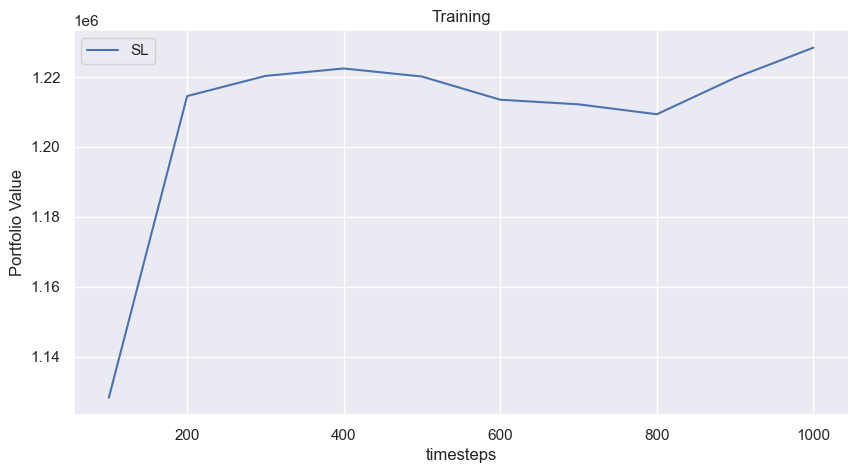

In [80]:
plt.plot(range(int(eval_freq), int(max_timesteps+1), int(eval_freq)), portfolio_values, label='SL')
plt.legend()
plt.title('Training')
plt.ylabel('Portfolio Value')
plt.xlabel('timesteps')
plt.show()

Text(0.5, 1.0, 'Training')

Text(0, 0.5, 'cumulative rewards')

Text(0.5, 0, 'timesteps')

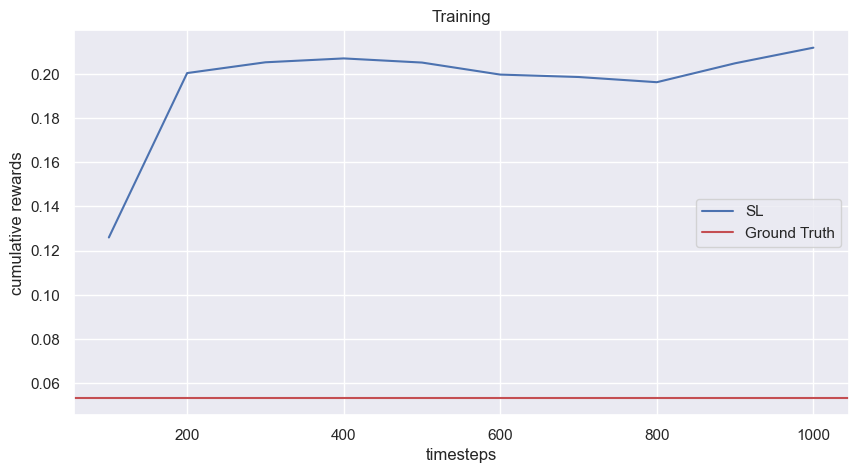

In [84]:
plt.plot(range(int(eval_freq), int(max_timesteps+1), int(eval_freq)), evaluations, label='SL')
plt.axhline(y=sum(retail_train["rewards"]), label='Ground Truth', color = 'r')
plt.legend()
plt.title('Training')
plt.ylabel('cumulative rewards')
plt.xlabel('timesteps')
plt.show()

Text(0.5, 1.0, 'Training')

Text(0, 0.5, 'MSE')

Text(0.5, 0, 'timesteps')

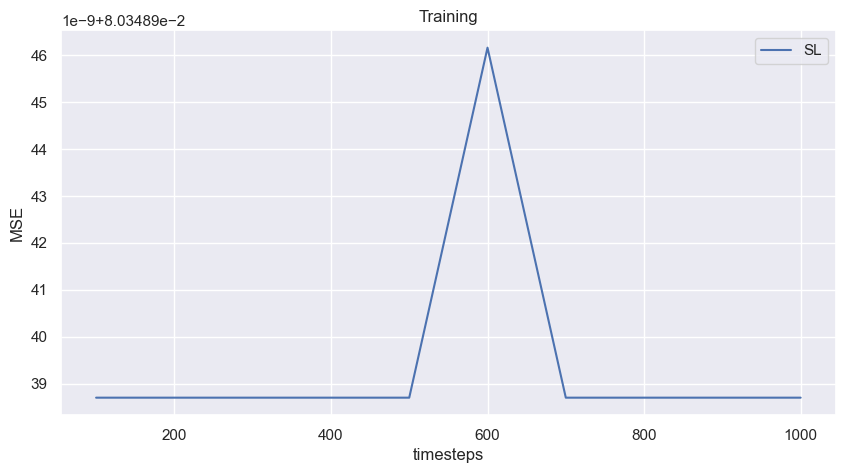

In [85]:
plt.plot(range(int(eval_freq), int(max_timesteps+1), int(eval_freq)), fitted, label='SL')
plt.legend()
plt.title('Training')
plt.ylabel('MSE')
plt.xlabel('timesteps')
plt.show()